In [51]:
import sys
sys.path.append('../Utils')
import Solve_Slice
from Solve_Slice import find_B, scatter_pies, solve_V_per_slice, laplacian_from_coords, solve_V_all_slices, find_B_music, select_informative_genes
from CreateRef import createscRef_py
import anndata as ad
import numpy as np
import scanpy as sp

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:

def assemble_blocks(diag_blocks, offdiag_blocks=()):
    """
    diag_blocks: list of 2D arrays (dense or sparse), block i has shape (ri, ci)
    offdiag_blocks: iterable of (i, j, Bij) where Bij has shape (ri, cj)

    Returns: CSR sparse matrix with the given diagonal and off-diagonal blocks.
    """
    # sizes per block row/column
    r_sizes = [b.shape[0] for b in diag_blocks]
    c_sizes = [b.shape[1] for b in diag_blocks]

    # total shape
    n_rows = sum(r_sizes)
    n_cols = sum(c_sizes)
    A = lil_matrix((n_rows, n_cols))

    # offsets
    r_off = np.r_[0, np.cumsum(r_sizes[:-1])]
    c_off = np.r_[0, np.cumsum(c_sizes[:-1])]

    # place diagonal blocks
    for i, Bii in enumerate(diag_blocks):
        r0, c0 = r_off[i], c_off[i]
        ri, ci = Bii.shape
        A[r0:r0+ri, c0:c0+ci] = Bii

    # place off-diagonal blocks
    for (i, j, Bij) in offdiag_blocks:
        ri, cj = r_sizes[i], c_sizes[j]
        if Bij.shape != (ri, cj):
            raise ValueError(f"Offdiag block ({i},{j}) must be shape {(ri, cj)}, got {Bij.shape}")
        r0, c0 = r_off[i], c_off[j]
        A[r0:r0+ri, c0:c0+cj] = Bij

    return A.tocsr()

In [53]:
adata = ad.read_h5ad("../Data/sc_data.h5ad")

B = find_B_music(adata)
B.to_numpy().shape

pd_B = B.T

genes_subset = select_informative_genes(pd_B)
print(len(genes_subset) )
print(pd_B.shape)
pd_B = pd_B.loc[:,genes_subset]
print(pd_B.shape)

15678
(20, 19736)
(20, 15678)


In [54]:
adata = ad.read_h5ad("../Data/spatial.h5ad")
import scanpy as sc
import scipy.sparse as sp
# --- 1) Remove non-finite values in X (works for dense or sparse) ---
if sp.issparse(adata.X):
    d = adata.X.data
    bad = ~np.isfinite(d)
    if bad.any():
        d[bad] = 0.0
else:
    adata.X = np.nan_to_num(adata.X, nan=0.0, posinf=0.0, neginf=0.0)

# (Optional) also sanitize any layers to be safe
for lyr in getattr(adata, "layers", {}) or {}:
    Xl = adata.layers[lyr]
    if sp.issparse(Xl):
        dl = Xl.data
        badl = ~np.isfinite(dl)
        if badl.any():
            dl[badl] = 0.0
    else:
        adata.layers[lyr] = np.nan_to_num(Xl, nan=0.0, posinf=0.0, neginf=0.0)

# --- 2) Basic preproc (HVG expects normalized/log data) ---
sc.pp.filter_genes(adata, min_counts=1)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.filter_genes(adata, min_counts=1)
n_top = 1000
sc.pp.highly_variable_genes(adata, n_top_genes=n_top)

mask = adata.var['highly_variable']
gene_names = adata.var_names[mask]
print(gene_names)

Index(['A2M', 'ABCA7', 'ABCF2', 'ABHD4', 'AC002350.1', 'AC004057.1',
       'AC004453.1', 'AC004552.1', 'AC004890.1', 'AC005156.1',
       ...
       'ZBTB3', 'ZC3H3', 'ZFP36L2', 'ZFPM1', 'ZKSCAN5', 'ZNF423', 'ZNF787',
       'ZNHIT1', 'ZNRF3', 'ZSWIM8'],
      dtype='object', length=1000)


In [55]:
def perturb_and_subsample(
    adata, frac=0.5, noise_std=None, dropout_p=None, seed=None
):
    
    rng = np.random.default_rng(seed)

    # --- Subsample rows (cells) ---
    n_obs = adata.n_obs
    n_keep = int(np.ceil(frac * n_obs))
    keep_idx = rng.choice(n_obs, n_keep, replace=False)
    adata_sub = adata[keep_idx].copy()

    # --- Perturb X if requested ---
    X = adata_sub.X
    if hasattr(X, "toarray"):  # convert sparse if needed
        X = X.toarray()

    if noise_std is not None:
        X = X + rng.normal(0, noise_std, size=X.shape)

    if dropout_p is not None:
        mask = rng.random(X.shape) < dropout_p
        X = X.copy()
        X[mask] = 0

    adata_sub.X = X
    adata_sub.uns["perturbation"] = dict(
        noise_std=noise_std, dropout_p=dropout_p, frac=frac
    )
    return adata_sub

adata_noisy = perturb_and_subsample(adata, noise_std=0.0, frac=0.5)
adata_noisy2 = perturb_and_subsample(adata, noise_std=0.0, frac=0.5)
adata_group = [adata_noisy2, adata_noisy]

/Users/wenjunzhao/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/wenjunzhao/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/wenjunzhao/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:488: RuntimeWarning: divide by zero encountered in matmul
  
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:488: RuntimeWarning: overflow encountered in matmul
  
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py

Index(['1-Mar', '1-Sep', '10-Mar', '10-Sep', '11-Sep', '14-Sep', '2-Mar',
       '2-Sep', '3-Mar', '3-Sep',
       ...
       'ZW10', 'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', length=15678)
(428, 1400)
(1400, 20)
iter    0  f=9.455373e+06  rel_drop=8.611e-03  step=6.25e-05
iter   34  f=8.867145e+06  rel_drop=9.741e-06  step=1.56e-05
stopped after iteration # 34
stopped after iteration #34
(428, 1400)
(1400, 20)
iter    0  f=9.455373e+06  rel_drop=8.611e-03  step=6.25e-05


/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:488: RuntimeWarning: divide by zero encountered in matmul
  
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:488: RuntimeWarning: overflow encountered in matmul
  
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:488: RuntimeWarning: invalid value encountered in matmul
  
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:490: RuntimeWarning: divide by zero encountered in matmul
  rel_drop = (f_prev - f_curr) / max(1.0, abs(f_prev))
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:490: RuntimeWarning: overflow encountered in matmul
  rel_drop = (f_prev - f_curr) / max(1.0, abs(f_prev))
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:490: RuntimeWarning: invalid value encountered in matmul
  rel_drop = (f_prev - f_curr) / max(1.0, abs(f_prev))
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:493: RuntimeWarning: divide by

iter   34  f=8.867145e+06  rel_drop=9.741e-06  step=1.56e-05
stopped after iteration # 34
stopped after iteration #34
(856, 1400)
(1400, 20)
iter    0  f=1.894716e+07  rel_drop=6.408e-03  step=6.25e-05


/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:603: RuntimeWarning: divide by zero encountered in matmul
  
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:603: RuntimeWarning: overflow encountered in matmul
  
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:603: RuntimeWarning: invalid value encountered in matmul
  
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:605: RuntimeWarning: divide by zero encountered in matmul
  plt.imshow(L.todense())
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:605: RuntimeWarning: overflow encountered in matmul
  plt.imshow(L.todense())
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:605: RuntimeWarning: invalid value encountered in matmul
  plt.imshow(L.todense())
/Users/wenjunzhao/Library/Python/3.9/lib/python/site-packages/ot/bregman/_sinkhorn.py:666: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations 

iter   30  f=1.773655e+07  rel_drop=9.033e-06  step=1.56e-05
stopped after iteration # 30
stopped after iteration #30
iter    0  f=1.773655e+07  rel_drop=-3.490e-05
(856, 1400)
(1400, 20)
iter    0  f=1.894716e+07  rel_drop=6.408e-03  step=6.25e-05
iter   30  f=1.773655e+07  rel_drop=9.033e-06  step=1.56e-05
stopped after iteration # 30
stopped after iteration #30
iter    1  f=1.773655e+07  rel_drop=-8.542e-11
(856, 1400)
(1400, 20)
iter    0  f=1.894716e+07  rel_drop=6.408e-03  step=6.25e-05
iter   30  f=1.773655e+07  rel_drop=9.033e-06  step=1.56e-05
stopped after iteration # 30
stopped after iteration #30
iter    2  f=1.773655e+07  rel_drop=0.000e+00
stopped after iteration # 2


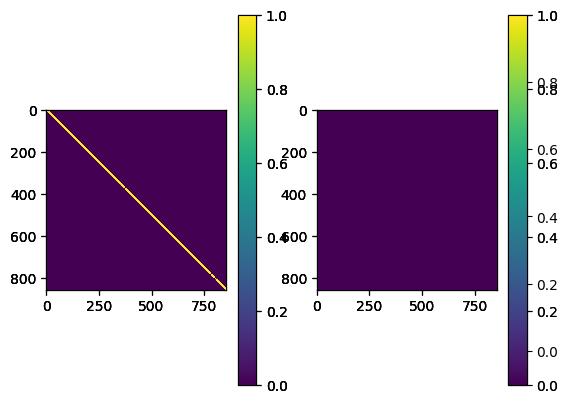

In [56]:

adata_noisy = perturb_and_subsample(adata, noise_std=0.0, frac=0.5)
adata_noisy2 = perturb_and_subsample(adata, noise_std=0.0, frac=0.5)
adata_group = [adata_noisy2, adata_noisy]
adata_group = [adata, adata]
V_all, pi, L = solve_V_all_slices(adata_group, pd_B, mu=1, lam=1000)

In [13]:
n_times = 2
lam = 1
diag_blocks = [0]*n_times
for i in range(n_times):
    x = adata_group[i].obs['x'].to_numpy()
    y = adata_group[i].obs['y'].to_numpy()
    diag_blocks[i], _ = laplacian_from_coords(x, y, k=20, normed=True)
    diag_blocks[i] = diag_blocks[i]*lam

In [48]:
genes_subset = select_informative_genes(pd_B_sub)
print(len(genes_subset) )
print(pd_B_sub.shape)

686
(20, 762)


In [19]:
from scipy.sparse import lil_matrix, csr_matrix
# Intersection with B’s index (genes as rows)
common = gene_names.intersection(pd_B.columns)
# print(common)
    # Subset AnnData and B, in the same order
adata_sub = adata[:, common].copy()
for i in range(n_times):
    adata_group[i] = adata_group[i][:,common].copy()
pd_B_sub = pd_B[common]

V_init = [0]*n_times
for i in range(n_times):
    V_init[i] = solve_V_per_slice(adata_group[i],pd_B_sub, lam=lam, preprocess=False)


V = np.vstack(V_init)
L  = assemble_blocks(diag_blocks, offdiag_blocks=[])#off_diag_blocks)

(428, 762)
(762, 20)
iter    0  f=5.456325e+06  rel_drop=2.719e-03  step=6.25e-05


/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:458: RuntimeWarning: divide by zero encountered in matmul
  R = X - B @ V.T
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:458: RuntimeWarning: overflow encountered in matmul
  R = X - B @ V.T
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:458: RuntimeWarning: invalid value encountered in matmul
  R = X - B @ V.T
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:460: RuntimeWarning: divide by zero encountered in matmul
  return np.sum(R*R) + np.linalg.trace(V.T @ L @ V)
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:460: RuntimeWarning: overflow encountered in matmul
  return np.sum(R*R) + np.linalg.trace(V.T @ L @ V)
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:460: RuntimeWarning: invalid value encountered in matmul
  return np.sum(R*R) + np.linalg.trace(V.T @ L @ V)
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Sli

iter   50  f=5.175184e+06  rel_drop=7.909e-05  step=1.56e-05
iter   72  f=5.169304e+06  rel_drop=4.271e-06  step=3.13e-05
stopped after iteration # 72
stopped after iteration #72
(428, 762)
(762, 20)
iter    0  f=5.456325e+06  rel_drop=2.719e-03  step=6.25e-05


/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:458: RuntimeWarning: divide by zero encountered in matmul
  R = X - B @ V.T
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:458: RuntimeWarning: overflow encountered in matmul
  R = X - B @ V.T
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:458: RuntimeWarning: invalid value encountered in matmul
  R = X - B @ V.T
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:460: RuntimeWarning: divide by zero encountered in matmul
  return np.sum(R*R) + np.linalg.trace(V.T @ L @ V)
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:460: RuntimeWarning: overflow encountered in matmul
  return np.sum(R*R) + np.linalg.trace(V.T @ L @ V)
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:460: RuntimeWarning: invalid value encountered in matmul
  return np.sum(R*R) + np.linalg.trace(V.T @ L @ V)
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Sli

iter   50  f=5.175184e+06  rel_drop=7.909e-05  step=1.56e-05
iter   72  f=5.169304e+06  rel_drop=4.271e-06  step=3.13e-05
stopped after iteration # 72
stopped after iteration #72


In [57]:
import scipy
import ot
mu = 100
off_diag_blocks = []
for i in range(n_times-1):
    a = np.ones(adata_group[i].obs.shape[0])/adata_group[i].obs.shape[0]
    b = np.ones(adata_group[i+1].obs.shape[0])/adata_group[i+1].obs.shape[0]
    C = scipy.spatial.distance.cdist(V_init[i], V_init[i+1], metric='cosine')

    pi[i] = ot.sinkhorn(a,b,C, reg=1e-2)

    norm1 = np.linalg.norm(V_init[i],axis=1)
    norm2 = np.linalg.norm(V_init[i+1],axis=1)

            # norm1[norm1 == 0] = 1e-10
            # norm2[norm2 == 0] = 1e-10
    denom = np.outer(norm1, norm2)
    denom[denom == 0] = 1e-10
    off_diag_blocks += [ (i,i+1,-mu*pi[i]/denom)  ]
    off_diag_blocks += [ (i+1,i,-mu*(pi[i]/denom).T)]
L0 = L.copy()
L  = assemble_blocks(diag_blocks)
L2 = assemble_blocks(diag_blocks, offdiag_blocks=off_diag_blocks)

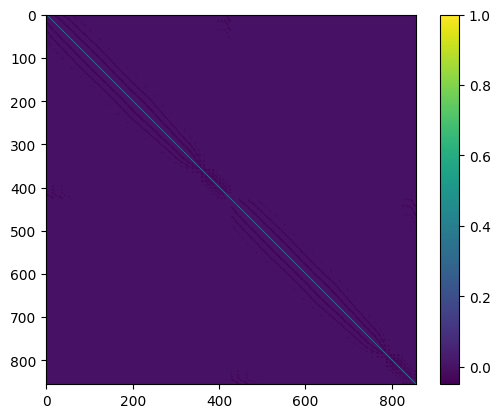

In [58]:
plt.imshow(L.todense())
plt.colorbar()

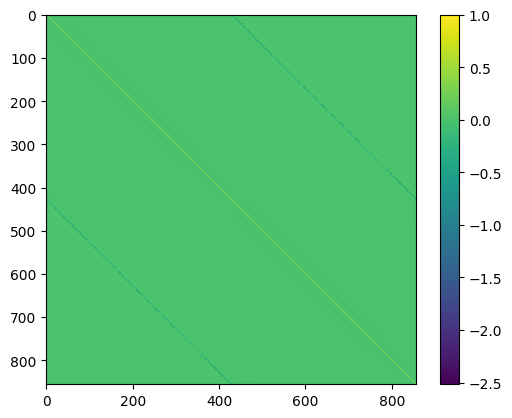

In [59]:
plt.imshow(L2.todense())
plt.colorbar()

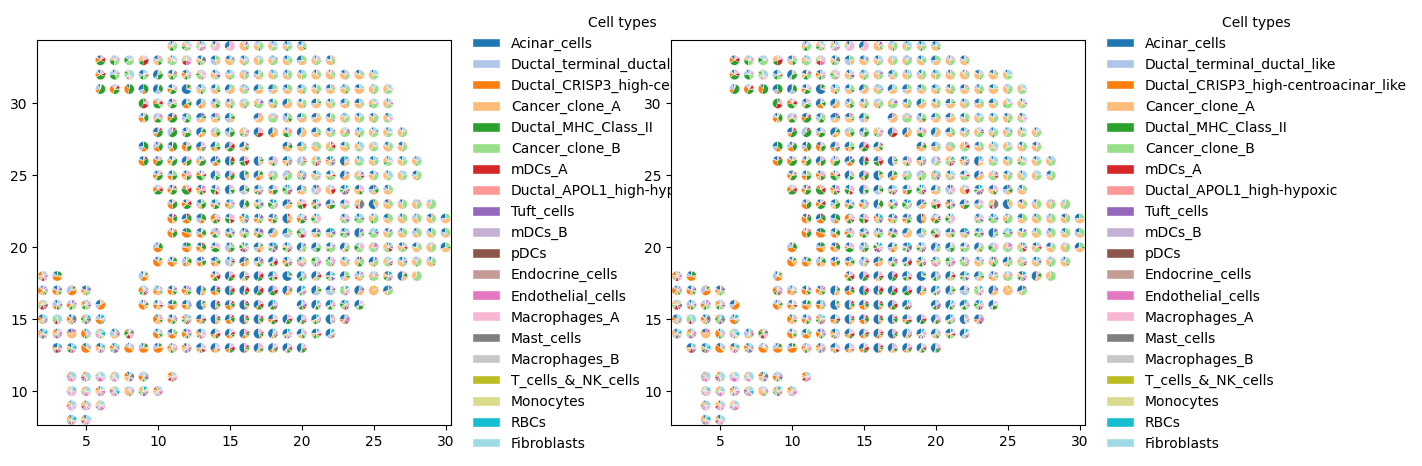

In [60]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(1, 2, figsize=(15, 5))
scatter_pies(axs[0], adata_group[0].obs['x'], adata_group[0].obs['y'], V_all[0], labels=pd_B.index.to_list(),top_n=None)
scatter_pies(axs[1], adata_group[1].obs['x'], adata_group[1].obs['y'], V_all[1], labels=pd_B.index.to_list(),top_n=None)

/Users/wenjunzhao/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/wenjunzhao/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/wenjunzhao/Library/Python/3.9/lib/python/site-packages/scanpy/_utils/__init__.py:555: RuntimeWarning: overflow encountered in multiply
  return x * y
/Users/wenjunzhao/Library/Python/3.9/lib/python/site-packages/scanpy/preprocessing/_utils.py:41: RuntimeWarning: overflow encountered in square
  var = mean_sq - mean**2
/Users/wenjunzhao/Library/Python/3.9/lib/python/site-packages/scanpy/preprocessing/_utils.py:41: RuntimeWarning: invalid value encountered in subtract
  var = mean_sq - mean**2
/Users/wenjunzhao/Library/Python/3.9/l

Index(['1-Mar', '1-Sep', '10-Mar', '10-Sep', '11-Sep', '14-Sep', '2-Mar',
       '2-Sep', '3-Mar', '3-Sep',
       ...
       'ZW10', 'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', length=15678)
(214, 1410)
(1410, 20)
iter    0  f=4.790024e+06  rel_drop=3.674e-02  step=3.91e-06
iter   50  f=4.516736e+06  rel_drop=1.501e-04  step=3.91e-06
iter   69  f=4.508580e+06  rel_drop=9.333e-07  step=7.81e-06
stopped after iteration # 69
stopped after iteration #69
(214, 1410)
(1410, 20)
iter    0  f=5.133087e+06  rel_drop=3.616e-02  step=3.91e-06


/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:473: RuntimeWarning: divide by zero encountered in matmul
  # candidate update
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:473: RuntimeWarning: overflow encountered in matmul
  # candidate update
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:473: RuntimeWarning: invalid value encountered in matmul
  # candidate update
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:488: RuntimeWarning: divide by zero encountered in matmul
  
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:488: RuntimeWarning: overflow encountered in matmul
  
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:488: RuntimeWarning: invalid value encountered in matmul
  
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:490: RuntimeWarning: divide by zero encountered in matmul
  rel_drop = (f_prev - f_curr) / max(1.0, abs(f_prev))
/Users/wenjunzhao/D

iter   47  f=4.856656e+06  rel_drop=8.524e-06  step=7.81e-06
stopped after iteration # 47
stopped after iteration #47
(428, 1410)
(1410, 20)
iter    0  f=9.921054e+06  rel_drop=3.575e-02  step=3.91e-06


/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:603: RuntimeWarning: divide by zero encountered in matmul
  
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:603: RuntimeWarning: overflow encountered in matmul
  
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:603: RuntimeWarning: invalid value encountered in matmul
  
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:605: RuntimeWarning: divide by zero encountered in matmul
  plt.imshow(L.todense())
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:605: RuntimeWarning: overflow encountered in matmul
  plt.imshow(L.todense())
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:605: RuntimeWarning: invalid value encountered in matmul
  plt.imshow(L.todense())
/Users/wenjunzhao/Library/Python/3.9/lib/python/site-packages/ot/bregman/_sinkhorn.py:666: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations 

iter   50  f=9.371636e+06  rel_drop=1.323e-04  step=3.91e-06
iter  100  f=9.342723e+06  rel_drop=2.645e-05  step=3.91e-06
iter  111  f=9.340393e+06  rel_drop=7.136e-06  step=7.81e-06
stopped after iteration # 111
stopped after iteration #111
iter    0  f=9.340393e+06  rel_drop=2.748e-03
(428, 1410)
(1410, 20)
iter    0  f=9.921054e+06  rel_drop=3.575e-02  step=3.91e-06
iter   50  f=9.371636e+06  rel_drop=1.323e-04  step=3.91e-06
iter  100  f=9.342723e+06  rel_drop=2.645e-05  step=3.91e-06
iter  111  f=9.340393e+06  rel_drop=7.136e-06  step=7.81e-06
stopped after iteration # 111
stopped after iteration #111
iter    1  f=9.340393e+06  rel_drop=-1.196e-08
(428, 1410)
(1410, 20)
iter    0  f=9.921054e+06  rel_drop=3.575e-02  step=3.91e-06
iter   50  f=9.371636e+06  rel_drop=1.323e-04  step=3.91e-06
iter  100  f=9.342723e+06  rel_drop=2.645e-05  step=3.91e-06
iter  111  f=9.340393e+06  rel_drop=7.136e-06  step=7.81e-06
stopped after iteration # 111
stopped after iteration #111
iter    2  f=

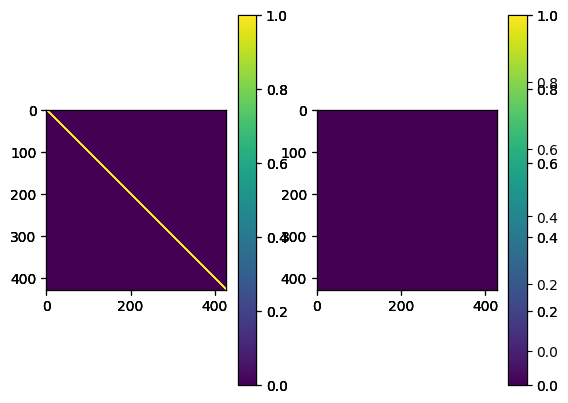

In [61]:
adata_noisy = perturb_and_subsample(adata, noise_std=0.0, frac=0.5)
adata_noisy2 = perturb_and_subsample(adata, noise_std=0.0, frac=0.5)
adata_group = [adata_noisy2, adata_noisy]
# adata_group = [adata, adata]
V_all, pi, L = solve_V_all_slices(adata_group, pd_B, mu=.5, lam=50)

Index(['1-Mar', '1-Sep', '10-Mar', '10-Sep', '11-Sep', '14-Sep', '2-Mar',
       '2-Sep', '3-Mar', '3-Sep',
       ...
       'ZW10', 'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', length=15678)
(428, 1400)
(1400, 20)
iter    0  f=9.420315e+06  rel_drop=1.168e-02  step=6.25e-05


/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:488: RuntimeWarning: divide by zero encountered in matmul
  
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:488: RuntimeWarning: overflow encountered in matmul
  
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:488: RuntimeWarning: invalid value encountered in matmul
  
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:490: RuntimeWarning: divide by zero encountered in matmul
  rel_drop = (f_prev - f_curr) / max(1.0, abs(f_prev))
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:490: RuntimeWarning: overflow encountered in matmul
  rel_drop = (f_prev - f_curr) / max(1.0, abs(f_prev))
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:490: RuntimeWarning: invalid value encountered in matmul
  rel_drop = (f_prev - f_curr) / max(1.0, abs(f_prev))
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:493: RuntimeWarning: divide by

iter   50  f=8.822182e+06  rel_drop=4.379e-05  step=1.56e-05
iter   73  f=8.817612e+06  rel_drop=9.416e-06  step=1.56e-05
stopped after iteration # 73
stopped after iteration #73
Index(['1-Mar', '1-Sep', '10-Mar', '10-Sep', '11-Sep', '14-Sep', '2-Mar',
       '2-Sep', '3-Mar', '3-Sep',
       ...
       'ZW10', 'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', length=15678)
(428, 1400)
(1400, 20)
iter    0  f=9.420315e+06  rel_drop=1.168e-02  step=6.25e-05


/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:488: RuntimeWarning: divide by zero encountered in matmul
  
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:488: RuntimeWarning: overflow encountered in matmul
  
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:488: RuntimeWarning: invalid value encountered in matmul
  
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:490: RuntimeWarning: divide by zero encountered in matmul
  rel_drop = (f_prev - f_curr) / max(1.0, abs(f_prev))
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:490: RuntimeWarning: overflow encountered in matmul
  rel_drop = (f_prev - f_curr) / max(1.0, abs(f_prev))
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:490: RuntimeWarning: invalid value encountered in matmul
  rel_drop = (f_prev - f_curr) / max(1.0, abs(f_prev))
/Users/wenjunzhao/Dropbox/ST-CARD/Scripts/../Utils/Solve_Slice.py:493: RuntimeWarning: divide by

iter   50  f=8.822182e+06  rel_drop=4.379e-05  step=1.56e-05
iter   73  f=8.817612e+06  rel_drop=9.416e-06  step=1.56e-05
stopped after iteration # 73
stopped after iteration #73


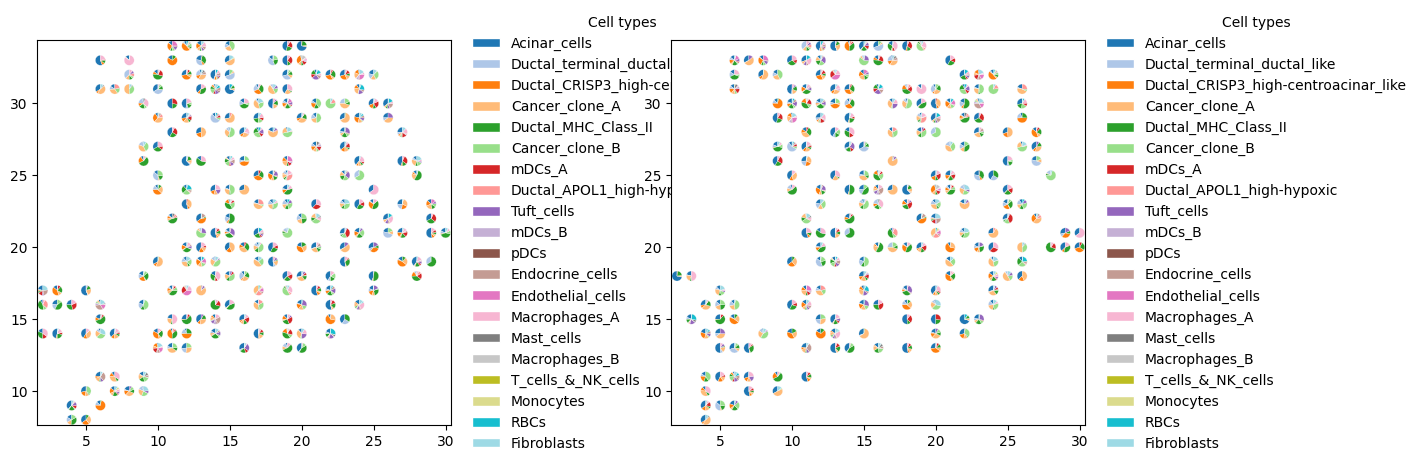

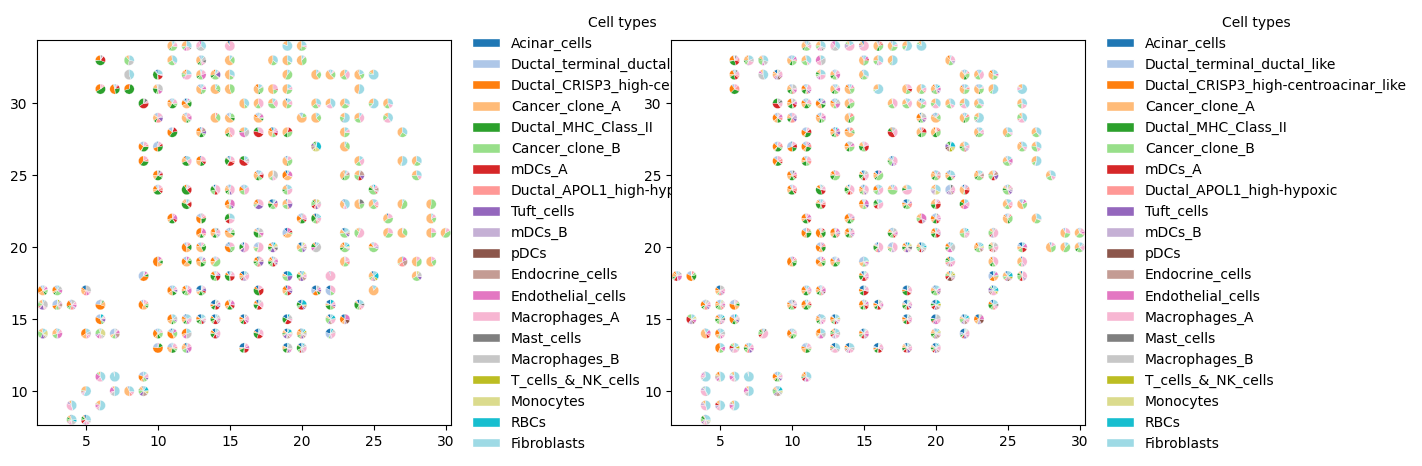

In [62]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

V = solve_V_per_slice(adata, pd_B, lam=1)
scatter_pies(axs[0], adata_group[0].obs['x'], adata_group[0].obs['y'], V, labels=pd_B.index.to_list(),top_n=None)
V = solve_V_per_slice(adata, pd_B, lam=1)
scatter_pies(axs[1], adata_group[1].obs['x'], adata_group[1].obs['y'], V, labels=pd_B.index.to_list(),top_n=None)


fig, axs = plt.subplots(1, 2, figsize=(15, 5))
scatter_pies(axs[0], adata_group[0].obs['x'], adata_group[0].obs['y'], V_all[0], labels=pd_B.index.to_list(),top_n=None)
scatter_pies(axs[1], adata_group[1].obs['x'], adata_group[1].obs['y'], V_all[1], labels=pd_B.index.to_list(),top_n=None)